# Add-ins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Cool lib to calculate metrics
import quantstats as qs

#to visualize loop iteration
from tqdm.notebook import tqdm

# Preprocessing

In [2]:
#read file
st_stocks = pd.read_csv('ticker_info.csv', header=0, index_col='Unnamed: 0')

In [3]:
#read file and convert date column to type datetime64[ns]
main_stocks = pd.read_csv('stock_data.csv', parse_dates=['date'])

In [4]:
#merge two files in one dataset
df_main = pd.merge(main_stocks, st_stocks, on=['ticker', 'ticker'])

In [26]:
'''Here we decided not to analyze delisted stocks.
The reason behind this fact as we don't know the exact delisted day. Thus, we can't just short them instantly.
As it will look like we 'peeking into the future' i.e. in test sample. 
What is more, we don't know exact methodology or model of predicting bancruptcy.
Therefore, let's simply drop these data. 
It is just 203 companies from 4000+, so we should not have a problem but make our model more reliable and accurate
'''

df_main = df_main[~df_main['company_name'].str.contains('ST')]

# Prices

In [50]:
''' To start, let's rearrange data to have simplier calcs. 
We will define tickers as columns and dates as indexes
'''

df_price = pd.pivot_table(df_main, values='close', index='date', columns='ticker', aggfunc=np.mean)

df_price.head()

ticker,sh600000,sh600004,sh600006,sh600007,sh600008,sh600009,sh600010,sh600011,sh600012,sh600015,...,sz301236,sz301237,sz301248,sz301256,sz301258,sz301259,sz301263,sz301268,sz301279,sz301288
date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,0.76,3.30,1.82,3.12,1.08,10.28,0.55,2.99,2.57,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,0.75,3.36,1.84,3.18,1.09,10.38,0.55,2.95,2.59,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,0.74,3.36,1.82,3.15,1.08,10.43,0.55,2.91,2.64,1.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,0.74,3.43,1.82,3.21,1.09,10.55,0.55,2.92,2.64,1.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,0.77,3.44,1.84,3.27,1.10,10.56,0.56,2.89,2.68,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
'''There are some missing data. Some stocks have missing data i.e. Nans. However than traded again.
For example, we have stocks that traded at 25/02/2005 but not traded at 28/02/2005. Meanwhile other stocks traded.
Therefore, we fill NaN based on the previous value (previous day) of this stock
'''

df_price = df_price.fillna(method='ffill')

# Parameters which will be fine-tuned

In [52]:
#Slice data for train/test/validation dataframe
df_price = df_price.loc['2022':'2022']

#major parameter - size of the rolling window
parameter = [15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 720]

#percentiles to long/short/flat stock
percentiles = [0.01, 0.99]

# Model

In [53]:
lst_strategies = [] #list of strategies which depend on the Rolling Window size

for i in tqdm(parameter):
    df_ratio = df_price / df_price.rolling(i).mean()

    strategy = np.where(df_ratio > df_ratio.quantile(percentiles[1]), -1, np.nan)
    strategy = np.where(df_ratio < df_ratio.quantile(percentiles[0]), 1, strategy)

    df_strategy = pd.DataFrame(strategy, columns=df_ratio.columns, index=df_ratio.index)
    df_strategy.ffill(inplace=True)
    lst_strategies.append(df_strategy)

  0%|          | 0/14 [00:00<?, ?it/s]

# Backtest

## Daily stocks return for each strategy

In [54]:
df_return = df_price.pct_change()

lst_pnl_daily_stock = [] #list of different strategy's daily returns for each stock for each day

for i in lst_strategies:
    result = i.shift(1) * df_return
    lst_pnl_daily_stock.append(result)

## Daily portfolio return for each strategy (weighted)

In [55]:
#weight of each stock by their price
df_weights = df_price.div(df_price.sum(axis=1), axis='rows')

lst_pnl_daily_portfolio = []

for i in lst_pnl_daily_stock: #weighed daily return for each stock by price
    result = (i * df_weights).sum(axis=1, skipna=True)
    lst_pnl_daily_portfolio.append(result)

## Combining all strategies in single dataframe

In [56]:
df_daily_return = pd.concat(lst_pnl_daily_portfolio, axis=1)
df_daily_return.columns = parameter

In [57]:
df_daily_return.tail()

,15,30,60,90,120,150,180,210,240,270,300,330,360,720
date,,,,,,,,,,,,,,
2022-05-05,0.013724,0.016120,0.018368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-06,-0.000816,0.001010,-0.000549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-09,0.010292,0.011890,0.012792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-10,0.017125,0.018456,0.021360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-11,0.012556,0.013051,0.016580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Buy and Hold strategy

In [58]:
#Simple buy and hold strategy, where we just long at t = 0. 
#We need this to compare the model with some benchmark
buy_and_hold_daily_return = (df_price.pct_change() * df_weights).sum(axis=1,skipna=True)

### Add Buy and Hold to main dataframe

In [59]:
df_daily_return.insert(0, 'Buy and Hold', buy_and_hold_daily_return)

In [60]:
#drop columns where we have no values i.e. strategy can't be applied to such dataset
df_daily_return = df_daily_return[df_daily_return.columns[(df_daily_return!=0).any(0)]]

In [61]:
df_daily_return.tail()

,Buy and Hold,15,30,60
date,,,,
2022-05-05,0.016951,0.013724,0.016120,0.018368
2022-05-06,-0.008603,-0.000816,0.001010,-0.000549
2022-05-09,0.009475,0.010292,0.011890,0.012792
2022-05-10,0.023496,0.017125,0.018456,0.021360
2022-05-11,0.015866,0.012556,0.013051,0.016580


# Metrics

## Sharpe Ratio

In [62]:
#Assume that China risk free is 5%
#Change annualize=False if data less than 1 year

series_sharpe = qs.stats.sharpe(df_daily_return, rf=0.05, annualize=False)
df_sharpe = pd.DataFrame(series_sharpe, columns=['Sharpe Ratio'])

## Maximum Drawdown

In [63]:
series_mdd = qs.stats.max_drawdown(df_daily_return)
df_mdd = pd.DataFrame(series_mdd, columns=['Maximum Drawdown'])

## Calmar Ratio 

In [64]:
series_calmar = qs.stats.calmar(df_daily_return)
df_calmar = pd.DataFrame(series_calmar, columns=['Calmar Ratio'])

# Combining all metrics in one dataframe

In [65]:
df_metrics = pd.concat([df_sharpe, df_mdd, df_calmar], axis=1)

In [66]:
df_metrics

,Sharpe Ratio,Maximum Drawdown,Calmar Ratio
Buy and Hold,-0.137950,-0.291534,-1.578988
15,0.585773,-0.006408,306.221557
30,0.585372,-0.004977,521.585300
60,0.423794,-0.000549,2951.448637


# Graph

In [67]:
rolling_return = qs.stats.compsum(df_daily_return) #rolling compounded returns

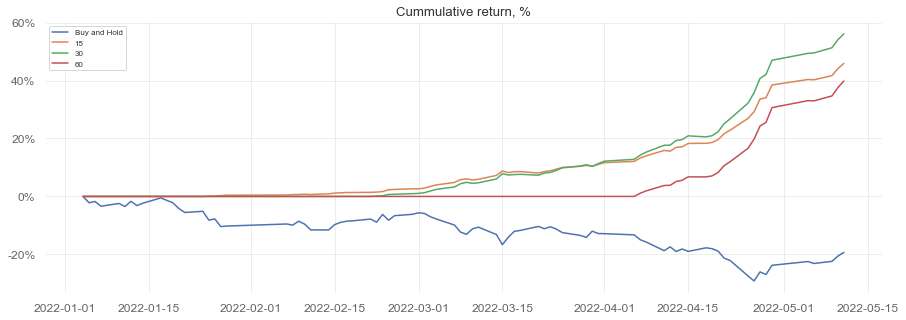

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(rolling_return)

#Add title
plt.title('Cummulative return, %')

#Change format for Y axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))

plt.rc('legend',fontsize=8) # using a size in points

plt.legend(df_daily_return.columns, loc='best')
plt.show()

# Save results in Excel

In [31]:
# Save Dashboard with main metrics

tag_1 = 'Dashboard - ' + str(df_price.index[0].year) + '-' + str(df_price.index[-1].year) + \
'; percentiles ' + str(percentiles[0]) + '%-' + str(percentiles[1]) + '%'
tag_1

df_metrics.to_excel(str(tag_1) + '.xlsx')

# Save Cummulative return
tag_2 = 'Cumulative return - ' + str(df_price.index[0].year) + '-' + str(df_price.index[-1].year) + \
'; percentiles ' + str(percentiles[0]) + '%-' + str(percentiles[1]) + '%'
tag_2

(rolling_return).to_excel(str(tag_2) + '.xlsx')